**Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

**Load in Scrapped Data**

In [3]:
dfpogo = pd.read_csv('Data/Pogo_scrape_fin.csv')

In [4]:
dfsilph = pd.read_csv('Data/Silph_scrape_fin.csv')

In [5]:
dfpogo.shape

(655, 103)

In [6]:
dfsilph.shape

(1048, 104)

**Processing Data**

The goal of this project is to determine if we can identify certain words or combinations of words that differentiate a post between the subreddits. Therefore, although there are definitely non-text features that would help us predict the subreddit, we wouldn't actually want to use those features since they would obscure the importance of the specific words.

In [6]:
dfpogotext = dfpogo[['selftext','title']].copy()

In [7]:
#determining that the pokemongo subreddit with be the "0" class feature
dfpogotext['target']=0

In [8]:
dfpogotext.shape

(655, 3)

In [9]:
dfpogotext.isnull().sum()

selftext    26
title        0
target       0
dtype: int64

In [10]:
dfpogotext.head()

,selftext,title,target
0,**[Rules](http://www.reddit.com/r/PokemonGo/wi...,"Weekly questions, bugs, and gameplay megathrea...",0
1,**Hey Niantic!** You guys made a game we all h...,DEAR NIANTIC - ideas and suggestions for the devs,0
2,http://imgur.com/gallery/mD62dyd\n\nreupload s...,"SCORE! Thanks, Mom!",0
3,NaN,Pokemon Go Team Rocket event details leaked by...,0
4,Long story short: for some time a I lived in G...,Make LUCKY TRADES available from afar like Bat...,0


Dropping first two rows of each subreddit since those are pinned posts that are very different than what standard posts in each subreddit would contain

In [11]:
dfpogotext.drop(0,inplace=True)

In [12]:
dfpogotext.drop(1,inplace=True)

In [13]:
dfsilphtext = dfsilph[['selftext','title']].copy()

In [14]:
#determining that the pokemongo subreddit with be the "0" class feature
dfsilphtext['target']=1

In [15]:
dfsilphtext.isnull().sum()

selftext    262
title         0
target        0
dtype: int64

In [16]:
dfsilphtext.head()

,selftext,title,target
0,Welcome travelers!\n\nSeeing as the Silph Road...,Welcome to the Silph Road! Here's what you nee...,1
1,NaN,Headed to GO Fest? Be sure to come say hello! ...,1
2,NaN,Apparently my hotel is a lake,1
3,Largely uninhabited areas would go completely ...,"With Team GO Rocket coming, it would be really...",1
4,NaN,TOP 20 COUNTERS - Armored Mewtwo [Now with ful...,1


In [17]:
dfsilphtext.drop(0,inplace=True)

In [18]:
dfsilphtext.drop(1,inplace=True)

In [19]:
#Use this function to replace any posts with a selftext of NaN to just an empty string
def replace_nan(row):
    if pd.isnull(row['selftext']):
        row['selftext'] = ""
    return row

In [20]:
dfpogotext = dfpogotext.apply(replace_nan,axis=1)

In [21]:
dfpogotext.head()

,selftext,title,target
2,http://imgur.com/gallery/mD62dyd\n\nreupload s...,"SCORE! Thanks, Mom!",0
3,,Pokemon Go Team Rocket event details leaked by...,0
4,Long story short: for some time a I lived in G...,Make LUCKY TRADES available from afar like Bat...,0
5,Tired of wasting TMs not getting the right mov...,TMs need to change.,0
6,I've had this little guy waiting patiently at ...,Finally caught my Shiny Sunglass Squirtle on t...,0


In [22]:
dfsilphtext = dfsilphtext.apply(replace_nan,axis=1)

In [23]:
#Since this is a pure text analysis, there's no need to keep the title text and post text seperate, combining with the added
#benefit that this addresses my posts with no post text
dfpogotext['combine']=dfpogotext['selftext']+" "+dfpogotext['title']
dfsilphtext['combine']=dfsilphtext['selftext']+" "+dfsilphtext['title']

In [24]:
#no need for the post text and title text columns now so removing those
dfsilphtext.drop(['selftext','title'],axis=1,inplace=True)
dfpogotext.drop(['selftext','title'],axis=1,inplace=True)

In [25]:
dfpogotext.head()

,target,combine
2,0,http://imgur.com/gallery/mD62dyd\n\nreupload s...
3,0,Pokemon Go Team Rocket event details leaked b...
4,0,Long story short: for some time a I lived in G...
5,0,Tired of wasting TMs not getting the right mov...
6,0,I've had this little guy waiting patiently at ...


In [26]:
dfpogotext.shape

(653, 2)

In [27]:
dfsilphtext.shape

(1046, 2)

**NLP Processing**

I want to create a function to tokenize my text, remove stop words, remove things that aren't words, and lementize/stem as well

First decide on if I want to stem or lemmatize

In [28]:
lemmatizer = WordNetLemmatizer()
p_stemmer = PorterStemmer()

In [29]:
lemmatizer.lemmatize('disappears')

'disappears'

In [30]:
lemmatizer.lemmatize('pikachu')

'pikachu'

In [31]:
lemmatizer.lemmatize('pokemons')

'pokemons'

In [32]:
lemmatizer.lemmatize('silph')

'silph'

In [33]:
p_stemmer.stem('disappears')

'disappear'

In [34]:
p_stemmer.stem('pikachu')

'pikachu'

In [35]:
p_stemmer.stem('pokemons')

'pokemon'

In [36]:
p_stemmer.stem('silph')

'silph'

In [37]:
p_stemmer.stem('bulbasaur')

'bulbasaur'

In [38]:
p_stemmer.stem('groudon')

'groudon'

In [39]:
p_stemmer.stem('charizard')

'charizard'

Seems like the porter stemmer is better, mostly wanted to make sure it didn't do weird things to pokemon names.
UPDATE: Decided to go with lemmatizing instead. Porter seems to cut off the ends of a lot of my words making many of my coefficients harder to interpret. The slight gain in model accuracy I gain from this doesn't seem worth this increase in interpretation.

Next figure out how to tokenize and process my strings

In [40]:
tokenizer = RegexpTokenizer('\s+', gaps=True)
stops = set(stopwords.words('english'))

In [41]:
#cell I'm testing things on
dfpogotext.iloc[30,1]

"I have a few regional Pokemon that I'm trying to trade my cousin (who doesn't have them yet). We've made a trade or two over the last week, but I've tried trading him another one today and it's just not showing up in my Pokemon list at all when I try to make the trade. It's there when I'm not trying to, but when we go to make a trade it just disappears completely.\n\nIs anyone else experiencing this issue? Like I said, we made a few trades just fine before, and now all of a sudden we're just unable to. Since he doesn't have them in his dex, I know about the Special Trade rules (can only do 1 a day) and we both absolutely have enough Stardust, so I'm confused as to why we can't make the trade. I've tried closing out of the app and restarting a few times, but it still won't work.\n\nCan someone assist? Having an Issue Trading Regional Pokemon"

In [45]:
def processText(raw_text):
    
    tokens = tokenizer.tokenize(raw_text)
    
    token_new=[]
    
    for token in tokens:
        if 'http://' in token: #identify websites linked in posts and try to extract the relevant info
            token_new.append(token.split('http://')[1].split('.')[0])
        else:
            result = re.sub("[^a-zA-Z]", "",token.replace("é","e").lower()) #replace the accented e that's something in pokemon
            if (result != '')&(result != 'ampxb'): #remove this word which seems to be an html artifact and adds no value
                if result not in stops:
                    token_new.append(lemmatizer.lemmatize(result))
    
    return(" ".join(token_new))

In [46]:
#verify function does what I want
processText(dfpogotext.iloc[30,1])

'regional pokemon im trying trade cousin doesnt yet weve made trade two last week ive tried trading another one today showing pokemon list try make trade im trying go make trade disappears completely anyone else experiencing issue like said made trade fine sudden unable since doesnt dex know special trade rule day absolutely enough stardust im confused cant make trade ive tried closing app restarting time still wont work someone assist issue trading regional pokemon'

In [47]:
dfpogotext.head()

,target,combine
2,0,http://imgur.com/gallery/mD62dyd\n\nreupload s...
3,0,Pokemon Go Team Rocket event details leaked b...
4,0,Long story short: for some time a I lived in G...
5,0,Tired of wasting TMs not getting the right mov...
6,0,I've had this little guy waiting patiently at ...


In [48]:
#apply function toi my dataframes
dfpogotext['combine']=dfpogotext['combine'].apply(processText)
dfsilphtext['combine']=dfsilphtext['combine'].apply(processText)

**Visualizations**

Determine Average Post Length (after stop word removal)

In [49]:
dfpogotext['len']=dfpogotext['combine'].apply(lambda x: len(x.split()))

In [50]:
dfsilphtext['len']=dfsilphtext['combine'].apply(lambda x: len(x.split()))

In [51]:
dfpogotext[dfpogotext['len']>200]

,target,combine,len
67,0,idea pop head recently pokemon go playertoplay...,221
167,0,im level trainer who bothered iv shinies prefe...,237
198,0,see sort open letter niantic summarized versio...,801
325,0,fell like game much potential there many thing...,219
652,0,tldr isnt bulbapedia wiki inside pokemon go ap...,278


In [52]:
dfsilphtext[dfsilphtext['len']>400]

,target,combine,len
19,1,hello hardcore player chance attend gofest chi...,466
162,1,may remember amazing posthttpswwwredditcomrthe...,3168
218,1,mewtwo coming back raid next wednesday new arm...,573
249,1,dortmund use specified entry gate chicago coul...,613
484,1,edit added alolan shinys table well spinda sin...,434


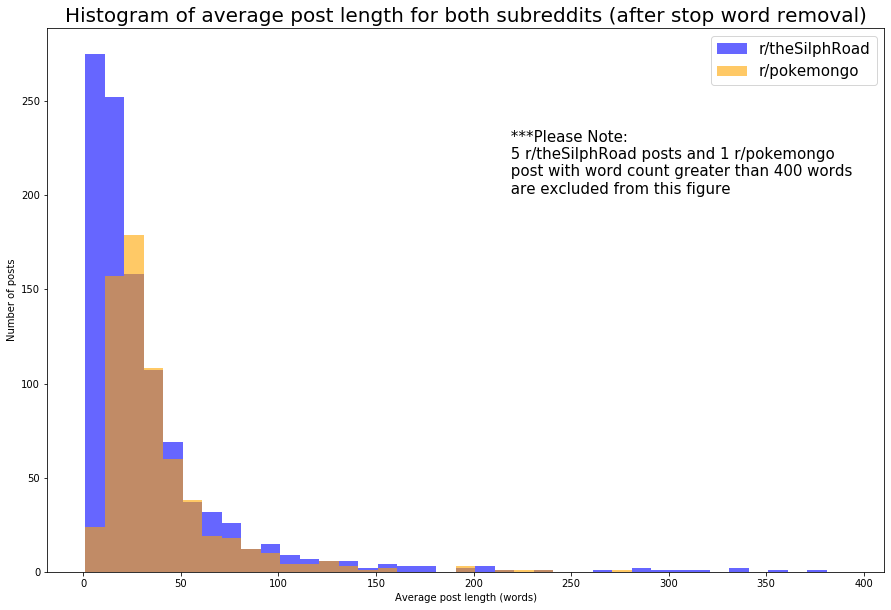

In [118]:
plt.figure(figsize=(15,10))

plt.title('Histogram of average post length for both subreddits (after stop word removal)', fontsize = 20)
plt.xlabel('Average post length (words)', fontsize = 10)
plt.ylabel('Number of posts', fontsize = 10)


plt.figtext(.55,.65," ***Please Note:\n 5 r/theSilphRoad posts and 1 r/pokemongo \n post with word count \
greater than 400 words \n are excluded from this figure",size=15)
plt.hist(dfsilphtext[dfsilphtext['len']<400]['len'],list(range(1,400,10)),alpha=.6,color='blue',label='r/theSilphRoad')
plt.hist(dfpogotext[dfpogotext['len']<400]['len'],list(range(1,400,10)),alpha=.6,color='orange',label='r/pokemongo')
plt.legend(fontsize=15);

Determine most common words (after stop word removal)

In [88]:
#Counting with countvectorizer so running that over the dataframe, converting the resulting sparse matrix to a
#dataframe and then summing up the columns to generate a horizontal bar plot
word_count = CountVectorizer(ngram_range = (1,2),max_features=15)
sparseX = word_count.fit_transform(dfsilphtext['combine'])
dfwc = pd.DataFrame(sparseX.toarray(),
                   columns=word_count.get_feature_names())

In [117]:
silphwords = dfwc.sum(axis=0).sort_values(ascending=True)

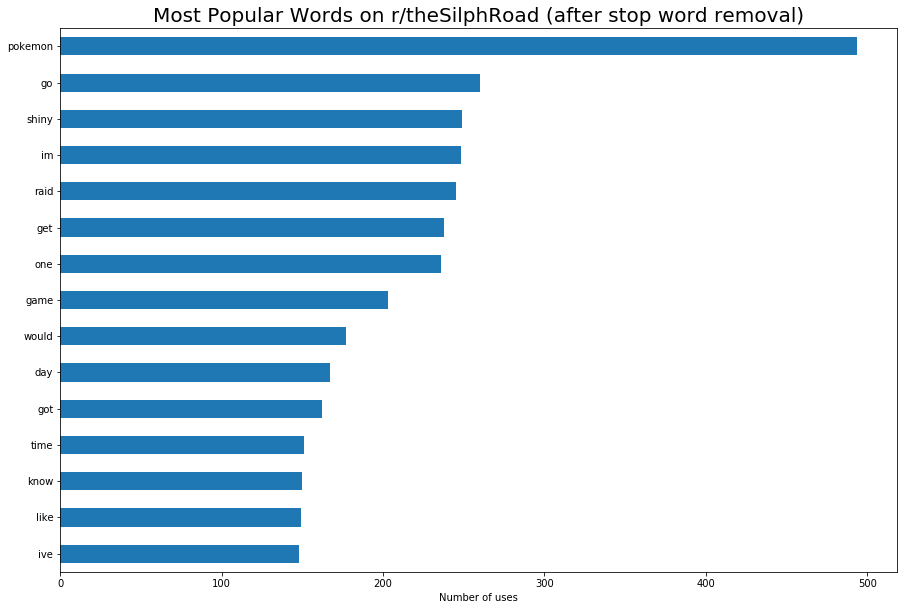

In [119]:
plt.figure(figsize=(15,10))
silphwords.plot.barh()
plt.title('Most Popular Words on r/theSilphRoad (after stop word removal)', fontsize = 20)
plt.xlabel('Number of uses', fontsize = 10);

In [91]:
word_count = CountVectorizer(ngram_range = (1,2),max_features=15)
sparseX = word_count.fit_transform(dfpogotext['combine'])
dfwc = pd.DataFrame(sparseX.toarray(),
                   columns=word_count.get_feature_names())

In [121]:
pogowords = dfwc.sum(axis=0).sort_values(ascending=True)

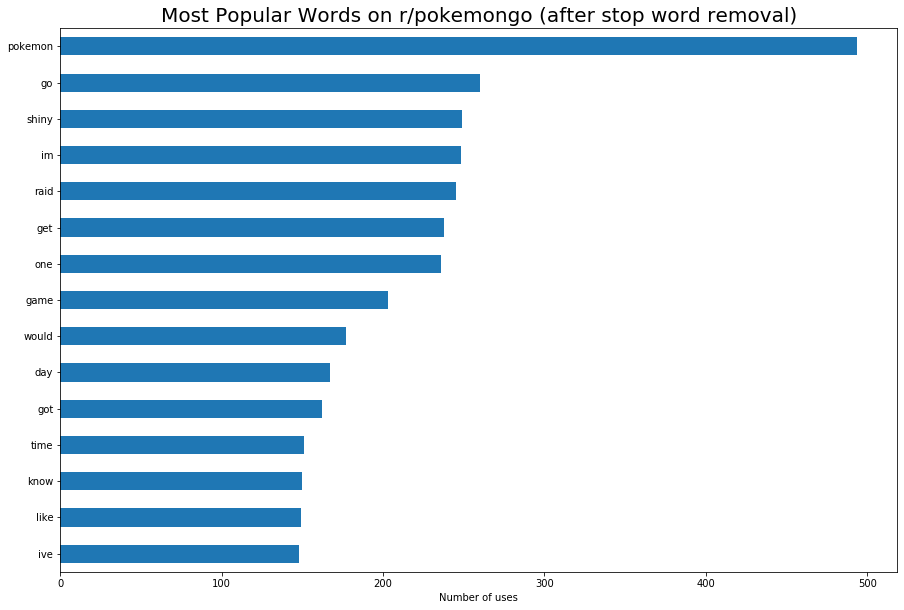

In [122]:
plt.figure(figsize=(15,10))
pogowords.plot.barh()
plt.title('Most Popular Words on r/pokemongo (after stop word removal)', fontsize = 20)
plt.xlabel('Number of uses', fontsize = 10);

Relating to my problem statement, I'm not feeling great about these results, it seems like many of my most common words are the same between the two subreddits. In addition, many of the posts for both subreddits have very low word counts which would make differentiating between the subreddits more difficult.

**Output data for Modeling**

In [58]:
df = pd.concat([dfpogotext,dfsilphtext],sort='False',ignore_index=True)

In [59]:
df.drop(columns='len',inplace=True)

In [60]:
df.head()

,combine,target
0,imgur reupload since posted photo sorry im kin...,0
1,pokemon go team rocket event detail leaked chr...,0
2,long story short time lived germany made frien...,0
3,tired wasting tm getting right move wasted fiv...,0
4,ive little guy waiting patiently front researc...,0


In [61]:
df.to_csv('Data/modelready_fin.csv',index=False)